In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.style.use('seaborn-dark-palette')
tex_fonts = {
    # Use LaTeX to write all text
    #     "text.usetex": True,
    "font.family": "sans-serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams.update(tex_fonts)
import drone_env
from drone_env import *
from tqdm import tqdm, trange
from IPython import display
from SAC_agents import RandomAgent, CriticNN
from collections import namedtuple, deque
from SAC_agents import *
import torch
import torch.nn as nn

# Checking the environment

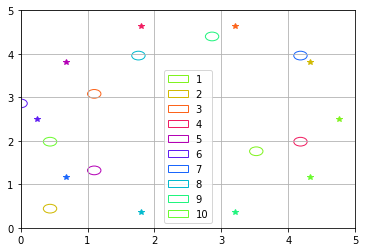

In [2]:
env = drone_env.drones(n_agents = 10, n_obstacles = 0, grid = [5,5], end_formation="O", simplify_zstate = True)
# print(env)
env.show()

## Simple gradient control. $ u_i = -\nabla _x c_i $

$$ c_i = q|| x_i-x_B ||^2 +  b \sum_{j \in N_i} \log (\frac{\hat{d}_i}{|| x_i-x_j || - r_i -r_j})$$

$$ \nabla _x c_i = 2q (x_i-x_B) - b \sum_{j \in N_i} \frac{1}{|| x_i-x_j || -r_i -r_j} \cdot \frac{x_i-x_j}{|| x_i -x_j ||} $$


100%|██████████| 500/500 [00:02<00:00, 189.80it/s]


Total collisions = 0


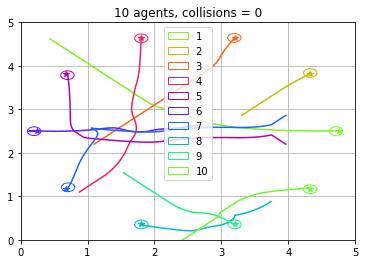

In [3]:
env = drone_env.drones(n_agents = 10, n_obstacles = 0, grid = [5,5], end_formation="O", simplify_zstate = True)


T = 5
times = np.arange(0,T,step=drone_env.dt) + drone_env.dt

total_collisions = 0
reward_history = np.zeros([len(times), env.n_agents])

trajectory = [env.state.copy()]

for iter,t in enumerate(tqdm(times)):
## Simple gradient controller u_i = -grad_i, assuming Nj = V
    state = env.state
    
    # calculate actions based on current state
    actions = drone_env.gradient_control(state,env)

    # Update environment one time step with the actions
    new_state, new_z, rewards, n_collisions, finished = env.step(actions)

    total_collisions += n_collisions
    reward_history[iter,:] = np.mean(rewards)
    trajectory.append(new_state.copy())

# print(env.trajectory[-1])
print(f"Total collisions = {total_collisions}")
env.plot(trajectory)

In [57]:
# env.animate(frame_time = 0.05, frames = 30)


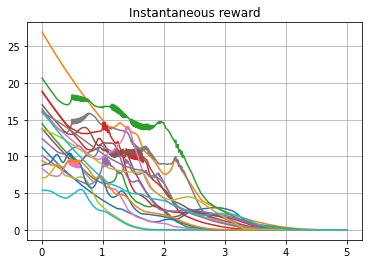

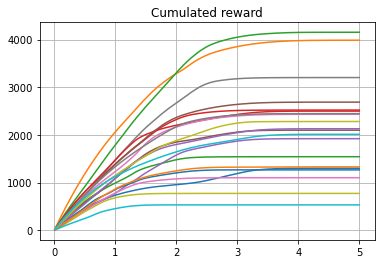

In [58]:
plt.plot(times,-reward_history);
plt.grid(True);
plt.title("Instantaneous reward")
plt.show()

cumulated_reward = np.cumsum(reward_history,0)

plt.plot(times,-cumulated_reward);
plt.grid(True);
plt.title("Cumulated reward")  
plt.show()

### Checking z state 

In [116]:

### Set up parameters ###
n_agents = 3
deltas = np.ones(n_agents)*2
env = drone_env.drones(n_agents=n_agents, n_obstacles=0, grid=[5, 5], end_formation="O", deltas=deltas ,simplify_zstate = True)
print(env)
# env.show()

N_Episodes = 1

T = 5 # Simulate for T seconds (default dt = drone_env.dt = 0.01s) t_iter t=500

### 

# Initialize variables
total_collisions_list = deque()
total_reward_list = deque()
mean_critic_error = np.zeros([env.n_agents, N_Episodes])
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

times = np.arange(0, T, step=drone_env.dt) + drone_env.dt
EPISODES = trange(N_Episodes, desc='Episode: ', leave=True)


agents = TrainedAgent(file_name="Q_test_1000eps-critics.pth", n_agents=env.n_agents)
print("### Running Trained agent (no learning)")
print(f"Episodes = {N_Episodes}, Time iterations = {len(times)} (T = {T}s, dt = {drone_env.dt}s)")
print(f"N of agents = {env.n_agents}")

for episode in EPISODES:

    # reward_history = np.zeros([len(times), env.n_agents])
    trajectory = [env.state.copy()]
    total_episode_reward = 0
    total_episode_collisions = 0
    # env.show()

    buffers = ExperienceBuffers(env.n_agents)
    # SIMULATION OVER T
    for t_iter, time in enumerate(times):
        # Simple gradient controller u_i = -grad_i, assuming Nj = V
        state = env.state
        z_states = env.z_states

        # calculate actions based on current state
        actions = drone_env.gradient_control(state, env)
        # actions = drone_env.proportional_control(state, env)

        # Update environment one time step with the actions
        new_state, new_z, rewards, n_collisions, finished = env.step(actions)
        # EXPERIECE: [z_state, action, reward, next_z, finished]
        buffers.append(z_states, actions, rewards,new_z, finished)

        total_episode_reward += np.mean(rewards)
        total_episode_collisions += n_collisions

        # reward_history[t_iter,:] = reward
        trajectory.append(new_state.copy())

    # END OF EPISODE
    # Append episode reward
    total_reward_list.append(total_episode_reward)
    total_collisions_list.append(total_episode_collisions)

    # Test Critic values
    Q_simulated, Q_approx = agents.benchmark_cirtic(buffers, only_one_NN=False)

    critic_error = [np.mean(np.power(Q_simulated[i]-Q_approx[i],2)) for i in range(env.n_agents)]

    mean_critic_error[:,episode] = np.array([critic_error])

    # print(f"Episode collisions = {total_episode_collisions}")
    # env.animate(trajectory,frame_time=0.1)

    # RESET ENVIRONMENT
    env.reset(renew_obstacles=False)

    # Set progress bar description with information
    average_reward = running_average(total_reward_list, 50)[-1]
    average_collisions = running_average(total_collisions_list, 50)[-1]
    EPISODES.set_description(
        f"Episode {episode} - Reward/Collisions/Steps: {total_episode_reward:.1f}/{total_episode_collisions}/{t_iter+1} - Average: {average_reward:.1f}/{average_collisions:.2f}/{t_iter+1}")

    # Plot current trajectory

    if episode >= N_Episodes-0:
        env.plot(trajectory)

        plt.figure()
        for i in range(env.n_agents):
            agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
            plt.plot(times,Q_simulated[i], label=f"i={i}, simulated Q", color = agent_color)
            plt.plot(times,Q_approx[i],"--" , label=f"i={i}, approx Q", color = tuple(0.9*x for x in agent_color))
        plt.legend()
        plt.show()


Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[4.4  4.18 0.   0.   0.1 ]
 [0.44 2.2  0.   0.   0.1 ]
 [0.66 1.54 0.   0.   0.1 ]]
safety distance for each agent:
 [3.69 3.69 3.69]
Deltas disk radius for each agent: 
 [2. 2. 2.]
Obstacles [x, y, r]:
 []



Episode:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded Critic, n_agents = 10, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=8, out_features=400, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=400, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
### Running Trained agent (no learning)
Episodes = 1, Time iterations = 500 (T = 5s, dt = 0.01s)
N of agents = 3


Episode 0 - Reward/Collisions/Steps: -265.6/0/500 - Average: 0.0/0.00/500: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


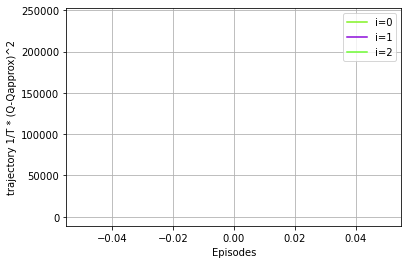

In [117]:
# plot_rewards(total_reward_list,total_collisions_list, n_ep_running_average=5)

plt.figure()
for i in range(env.n_agents):
        agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
        plt.plot(range(N_Episodes),mean_critic_error[i,:], label=f"i={i}", color = agent_color)
plt.xlabel("Episodes")
plt.ylabel("trajectory 1/T * (Q-Qapprox)^2")
plt.legend()
plt.grid()
plt.show()

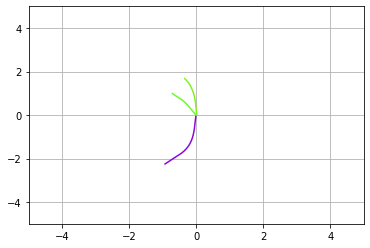

In [118]:

plt.figure()
plt.grid()
plt.xlim(-5,5)
plt.ylim(-5,5)

for i in range (env.n_agents):
    z_states_agent = [exp.z_state for exp in buffers.buffers[i]]

    zi = np.zeros([len(z_states_agent), 2])
    zj1 = np.zeros([len(z_states_agent), 2])
    zj2 = np.zeros([len(z_states_agent), 2])

    for t, z_sate in enumerate(z_states_agent):
        zi[t,:]  = z_sate[0:2]
        zj1[t,:] = z_sate[2:4]
        zj2[t,:] = z_sate[4:6]

    agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
    plt.plot(zi[:,0],zi[:,1], color = agent_color)

plt.show()

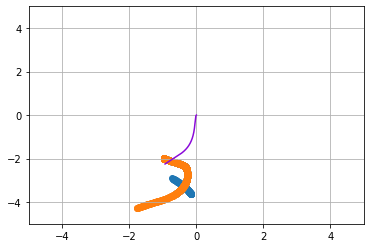

In [123]:
plt.figure()
plt.grid()
plt.xlim(-5,5)
plt.ylim(-5,5)

i = 1
z_states_agent = [exp.z_state for exp in buffers.buffers[i]]

zi = np.zeros([len(z_states_agent), 2])
zj1 = np.zeros([len(z_states_agent), 2])
zj2 = np.zeros([len(z_states_agent), 2])

for t, z_sate in enumerate(z_states_agent):
    zi[t,:]  = z_sate[0:2]
    zj1[t,:] = z_sate[2:4] + zi[t,:]
    zj2[t,:] = z_sate[4:6] + zi[t,:]

agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
plt.plot(zi[:,0],zi[:,1], color = agent_color)
plt.scatter(zj1[:,0],zj1[:,1])
plt.scatter(zj2[:,0],zj2[:,1])

plt.show()

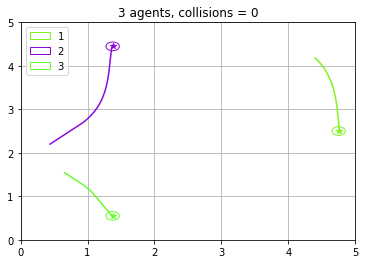

In [119]:
env.plot(trajectory)

In [ ]:
env.animate(trajectory)

### Tests

In [308]:

### Set up parameters ###
n_agents = 4
deltas = np.ones(n_agents)*2
env = drone_env.drones(n_agents=n_agents, n_obstacles=0, grid=[5, 5], end_formation="O", deltas=deltas ,simplify_zstate = True)
print(env)
# env.show()

N_Episodes = 5
plot_last = 2

T = 5 # Simulate for T seconds (default dt = drone_env.dt = 0.05s) t_iter t=100
discount_factor = 0.99
alpha_critic = 10**-2
alpha_actor = 10**-5
M = 50 # Epochs, i.e steps of the SDG for the critic NN
dim_z = env.local_state_space # Dimension of the localized z_state space
dim_a = env.local_action_space # Dimension of the local action space

### 

# Initialize variables
total_collisions_per_episode = []
total_reward_per_episode = []
grad_per_episode = np.zeros([N_Episodes, n_agents])
gi_per_episode = np.zeros_like(grad_per_episode)

times = np.arange(0, T, step=drone_env.dt) + drone_env.dt


agents = SA2CAgents(n_agents=env.n_agents, dim_local_state = dim_z, dim_local_action=dim_a, discount=discount_factor, epochs=M, learning_rate_critic=alpha_critic, learning_rate_actor=alpha_critic)
print("### Running Scalable-Actor-Critic with params: ###")
print(f"Episodes = {N_Episodes}, Time iterations = {len(times)} (T = {T}s, dt = {drone_env.dt}s)")
print(f"N of agents = {env.n_agents}, structure of critic NN = {agents.criticsNN[0].input_size}x{agents.criticsNN[0].L1}x{agents.criticsNN[0].L2}x{agents.criticsNN[0].output_size}")
print(f"Discount = {discount_factor}, lr for NN critical  = {alpha_critic}, lr for actor  = {alpha_actor}, epochs M = {M}")

EPISODES = trange(N_Episodes, desc='Episode: ', leave=True)
for episode in EPISODES:

    if episode >= N_Episodes-plot_last:
        # reward_history = np.zeros([len(times), env.n_agents])
        trajectory = [env.state.copy()]
    total_episode_reward = 0
    total_episode_collisions = 0
    # env.show()

    buffers = ExperienceBuffers(env.n_agents)
    # SIMULATION OVER T
    for t_iter, time in enumerate(times):
        # Simple gradient controller u_i = -grad_i, assuming Nj = V
        state = env.state
        z_states = env.z_states
        Ni = env.Ni

        # calculate actions based on current state
        # actions = drone_env.gradient_control(state, env)
        # actions = drone_env.proportional_control(state, env)
        actions = agents.forward(z_states, Ni)

        # Update environment one time step with the actions
        new_state, new_z, rewards, n_collisions, finished = env.step(actions)
        # EXPERIECE: [z_state, action, reward, next_z, finished]
        buffers.append(z_states, actions, rewards,new_z, Ni,finished)

        total_episode_reward += np.mean(rewards)
        total_episode_collisions += n_collisions

        if episode >= N_Episodes-plot_last:
            # reward_history[t_iter,:] = reward
            trajectory.append(new_state.copy())

    ### END OF EPISODES
    # Train of critic with the data of the episode
    current_grad_norms, current_gi_norms = agents.train(buffers, actor_lr = alpha_actor, return_grads=True)

    # Append episodic variables/logs
    total_reward_per_episode.append(total_episode_reward)
    total_collisions_per_episode.append(total_episode_collisions)
    grad_per_episode[episode,:] = np.array(current_grad_norms)
    gi_per_episode[episode,:] = np.array(current_gi_norms)

    if episode >= N_Episodes-plot_last:
        Q_simulated, Q_approx = agents.benchmark_cirtic(buffers, only_one_NN=False)

    # print(f"Episode collisions = {total_episode_collisions}")
    # env.animate(trajectory,frame_time=0.1)

    # RESET ENVIRONMENT
    env.reset(renew_obstacles=False)

    # Set progress bar description with information
    average_reward = running_average(total_reward_per_episode, 50)[-1]
    average_collisions = running_average(total_collisions_per_episode, 50)[-1]
    EPISODES.set_description(
        f"Episode {episode} - Reward/Collisions/Steps: {total_episode_reward:.1f}/{total_episode_collisions}/{t_iter+1} - Average: {average_reward:.1f}/{average_collisions:.2f}/{t_iter+1}")

    # Plot current trajectory

    if episode >= N_Episodes-plot_last:
        env.plot(trajectory)

        plt.figure()
        for i in range(env.n_agents):
            agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
            plt.plot(times,Q_approx[i], label=f"i={i}, approx Q")
            plt.plot(times,Q_simulated[i], "--", label=f"i={i}, simulated Q")
            print(f"Agent {i+1} params = \n{agents.actors[i].parameters}")
        plt.legend()
        plt.show()

agents.save(filename="trained")

plot_rewards(total_reward_per_episode,total_collisions_per_episode, n_ep_running_average=50)
plot_grads(grad_per_episode,gi_per_episode)

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[3.74 3.96 0.   0.   0.1 ]
 [3.74 1.98 0.   0.   0.1 ]
 [1.32 3.74 0.   0.   0.1 ]
 [3.96 1.76 0.   0.   0.1 ]]
safety distance for each agent:
 [2.98 2.98 2.98 2.98]
Deltas disk radius for each agent: 
 [2. 2. 2. 2.]
Obstacles [x, y, r]:
 []

### Running Scalable-Actor-Critic with params: ###
Episodes = 5, Time iterations = 100 (T = 5s, dt = 0.05s)
N of agents = 4, structure of critic NN = 8x200x200x1
Discount = 0.99, lr for NN critical  = 0.01, lr for actor  = 1e-05, epochs M = 50


Episode:   0%|          | 0/5 [00:01<?, ?it/s]


TypeError: 'int' object is not iterable

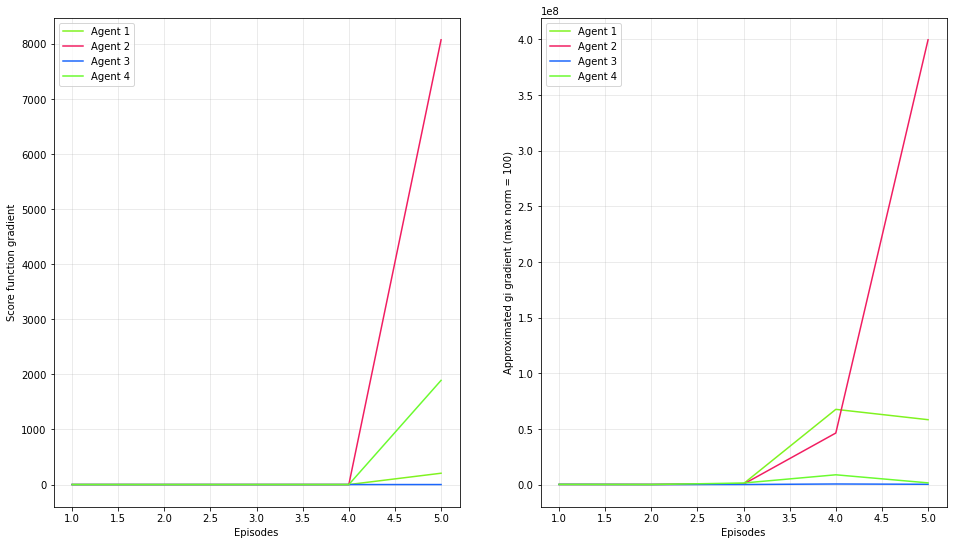

In [307]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
gi_per_episode
grad_per_episode

episode_variable = [e for e in range(1, len(grad_per_episode)+1)]

for i in range(n_agents):
    agent_color = drone_env.num_to_rgb(i,n_agents-1)
    ax[0].plot(episode_variable, grad_per_episode[:,i], label=f"Agent {i+1}", color = agent_color)
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Score function gradient')
ax[0].set_title('Score function gradient')
ax[0].legend()
ax[0].grid(alpha=0.3)

for i in range(n_agents):
    agent_color = drone_env.num_to_rgb(i,n_agents-1)
    ax[1].plot(episode_variable, gi_per_episode[:,i], label=f"Agent {i+1}", color = agent_color)
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Approximated gi gradient (max norm = 100)')
ax[1].set_title('Approximated gi gradient')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.show()

### Numerical gradients

In [112]:
from autograd import numpy as anp
from autograd import grad

In [ ]:
# def my_fun(variable):
#     Ni = [1,2]
#     idx = np.arange(1,int(z_len/dim+1))<=len(Ni)
#     R0 = anp.array([[anp.cos(variable[0]), -anp.sin(variable[0])],[anp.sin(variable[0]),anp.cos(variable[0])]])*idx[0]
#     R1 = anp.array([[anp.cos(variable[1]), -anp.sin(variable[1])],[anp.sin(variable[1]),anp.cos(variable[1])]])*idx[1]
#     R2 = anp.array([[anp.cos(variable[2]), -anp.sin(variable[2])],[anp.sin(variable[2]),anp.cos(variable[2])]])*idx[2]
#     R = anp.concatenate((R0,R1,R2),1)

#     return (-1/2*(a- R @ z).T @ np.linalg.inv(Sigma) @ (a- R @ z))[0,0]

# print(my_fun(theta))

# fun_grad = grad(my_fun)

initial angles = 
 [0. 0. 0.]
t(50): a-Rz = -2.5009202406018622
Final angles = 
 [ 9.23614626e-05 -8.65305668e-02 -8.53332695e-02]
[[ 0.  0.]
 [-0.  0.]]
t(99): a-Rz = -2.5009202406018622


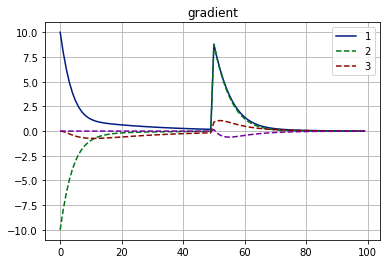

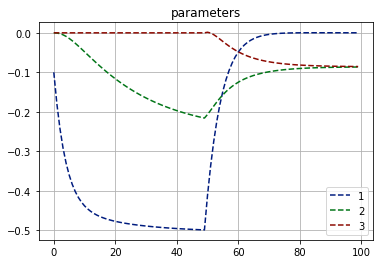

In [214]:
z_dim = 6
dim = 2
z = np.array([[2,0,0,1,0,-1]]).T
a = np.array([[2,0.0]]).T
Ni=[1,2]
idx = np.arange(1,int(z_dim/dim+1))<=len(Ni)
T = 100

policy = NormalPolicy(z_dim,dim, anp.array([[0.2,0],[0,0.2]]))

print("initial angles = \n",policy.parameters)
grad_norms = []
params = np.zeros([T,3])
grads = np.zeros([T,3])

for t in range(T):
    if t == int(T/2):
        # a = np.array([[1,1]]).T
        # z = -np.array([[0.5,2,1,2.5,1,1]]).T
        Ni = [1,2,3]
        print(f"t({t}): a-Rz = {(-1/2*(a- R @ z).T @ np.linalg.inv(policy.Sigma) @ (a- R @ z))[0,0]}")

    log_grad = policy.compute_grad(z.flatten(),a.flatten(),Ni)
    grad_norms.append(np.linalg.norm(log_grad))
    # print(f"params = {policy.parameters}, grad = {log_grad}")
    policy.parameters += log_grad*10**-2
    params[t,:] = policy.parameters
    grads[t,:] = policy.grad

print("Final angles = \n",policy.parameters)

variable = params[-1,:]
R0 = anp.array([[anp.cos(variable[0]), -anp.sin(variable[0])],[anp.sin(variable[0]),anp.cos(variable[0])]])*idx[0]
R1 = anp.array([[anp.cos(variable[1]), -anp.sin(variable[1])],[anp.sin(variable[1]),anp.cos(variable[1])]])*idx[1]
R2 = anp.array([[anp.cos(variable[2]), -anp.sin(variable[2])],[anp.sin(variable[2]),anp.cos(variable[2])]])*idx[2]
print(R2)
R = anp.concatenate((R0,R1,R2),1)

print(f"t({t}): a-Rz = {(-1/2*(a- R @ z).T @ np.linalg.inv(policy.Sigma) @ (a- R @ z))[0,0]}")

plt.figure()
# plt.plot(range(T),grad_norms)
plt.plot(range(T),grad_norms,range(T),grads,"--")
plt.legend(["1","2","3"])
plt.grid()
plt.title("gradient")
plt.show()

plt.figure()
style = ["--","--","--"]
for i in range(3):
    plt.plot(range(T),params[:,i],style[i],)
plt.legend(["1","2","3"])
plt.grid()
plt.title("parameters")
plt.show()
    


In [6]:
np.pi/1.5

2.0943951023931953

## Frame plot test

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[3.3  1.76 0.   0.   0.1 ]
 [1.76 4.62 0.   0.   0.1 ]
 [0.66 1.32 0.   0.   0.1 ]
 [4.4  1.32 0.   0.   0.1 ]
 [2.64 1.32 0.   0.   0.1 ]]
safety distance for each agent:
 [2.44 2.44 2.44 2.44 2.44]
Deltas disk radius for each agent: 
 [1. 1. 1. 1. 1.]
Obstacles [x, y, r]:
 []

### Running Scalable-Actor-Critic with params: ###
Episodes = 1, max Time iterations = 200 (T = 10.0s, dt = 0.05s)
N of agents = 5, structure of critic NN = 6x200x200x1
Discount = 0.99, lr for NN critical  = 0.01, lr for actor  = 0.0001, epochs M = 2


Episode 0 - Reward/Collisions/Steps: -15.2/0/163 - Average: 0.0/0.00/163:   0%|          | 0/1 [00:01<?, ?it/s]

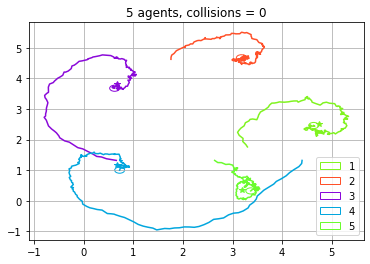

Agent 0 params = [-1.99784584 -2.0002238  -2.00103492]
Agent 1 params = [-1.99986205 -2.         -2.        ]
Agent 2 params = [-2.00447045 -2.         -2.        ]
Agent 3 params = [-1.9901917  -2.00194866 -2.        ]
Agent 4 params = [-2.00123284 -1.99876388 -1.99994488]


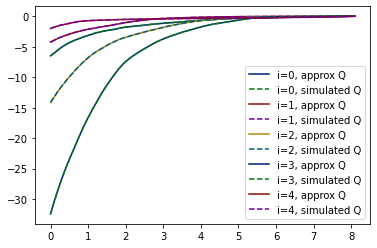

Episode 0 - Reward/Collisions/Steps: -15.2/0/163 - Average: 0.0/0.00/163: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


In [4]:
### Set up parameters ###
n_agents = 5
deltas = np.ones(n_agents)*1
# deltas = None
env = drone_env.drones(n_agents=n_agents, n_obstacles=0, grid=[5, 5], end_formation="O", deltas=deltas ,simplify_zstate = True)
print(env)
# env.show()

N_Episodes = 1  
plot_last = 1

# T = 8 # Simulate for T seconds (default dt = drone_env.dt = 0.05s) t_iter t=80
discount_factor = 0.99
alpha_critic = 10**-2
alpha_actor = 10**-4
M = 2 # Epochs, i.e steps of the SDG for the critic NN
dim_z = env.local_state_space # Dimension of the localized z_state space
dim_a = env.local_action_space # Dimension of the local action space

### 

# Initialize variables
total_collisions_per_episode = []
total_reward_per_episode = []
grad_per_episode = np.zeros([N_Episodes, n_agents])
gi_per_episode = np.zeros_like(grad_per_episode)

# times = np.arange(0, T, step=drone_env.dt) + drone_env.dt


agents = SACAgents(n_agents=env.n_agents, dim_local_state = dim_z, dim_local_action=dim_a, discount=discount_factor, epochs=M, learning_rate_critic=alpha_critic, learning_rate_actor=alpha_critic)
print("### Running Scalable-Actor-Critic with params: ###")
print(f"Episodes = {N_Episodes}, max Time iterations = {drone_env.max_time_steps} (T = {drone_env.max_time_steps * drone_env.dt}s, dt = {drone_env.dt}s)")
print(f"N of agents = {env.n_agents}, structure of critic NN = {agents.criticsNN[0].input_size}x{agents.criticsNN[0].L1}x{agents.criticsNN[0].L2}x{agents.criticsNN[0].output_size}")
print(f"Discount = {discount_factor}, lr for NN critical  = {alpha_critic}, lr for actor  = {alpha_actor}, epochs M = {M}")

EPISODES = trange(N_Episodes, desc='Episode: ', leave=True)
for episode in EPISODES:

    if episode >= N_Episodes-plot_last:
        # reward_history = np.zeros([len(times), env.n_agents])
        trajectory = [env.state.copy()]
        z_trajectory = [env.z_states]
    total_episode_reward = 0
    total_episode_collisions = 0
    # env.show()

    buffers = ExperienceBuffers(env.n_agents)

    # SIMULATION OVER T
    t_iter = 0
    finished = False
    while not finished:
        # Simple gradient controller u_i = -grad_i, assuming Nj = V
        state = env.state
        z_states = env.z_states
        Ni = env.Ni

        # calculate actions based on current state
        # actions = drone_env.gradient_control(state, env)
        # actions = drone_env.proportional_control(state, env)
        actions = agents.forward(z_states, Ni)
        # actions = agents.forward(z_states, Ni)

        # Update environment one time step with the actions
        new_state, new_z, rewards, n_collisions, finished = env.step(actions)
        # EXPERIECE: [z_state, action, reward, next_z, finished]
        buffers.append(z_states, actions, rewards,new_z, Ni,finished)

        total_episode_reward += np.mean(rewards)
        total_episode_collisions += n_collisions

        if episode >= N_Episodes-plot_last:
            # reward_history[t_iter,:] = reward
            trajectory.append(new_state.copy())
            z_trajectory.append(new_z)
        
        t_iter +=1

    ### END OF EPISODES
    # Train of critic with the data of the episode
    current_grad_norms, current_gi_norms = agents.train(buffers, actor_lr = alpha_actor, return_grads=True)

    # Append episodic variables/logs
    total_reward_per_episode.append(total_episode_reward)
    total_collisions_per_episode.append(total_episode_collisions)
    grad_per_episode[episode,:] = np.array(current_grad_norms)
    gi_per_episode[episode,:] = np.array(current_gi_norms)

    if episode >= N_Episodes-plot_last:
        Q_simulated, Q_approx = agents.benchmark_cirtic(buffers, only_one_NN=False)

    # print(f"Episode collisions = {total_episode_collisions}")
    # env.animate(trajectory,frame_time=0.1)

    # RESET ENVIRONMENT
    env.reset(renew_obstacles=False)

    # Set progress bar description with information
    average_reward = running_average(total_reward_per_episode, 50)[-1]
    average_collisions = running_average(total_collisions_per_episode, 50)[-1]
    EPISODES.set_description(
        f"Episode {episode} - Reward/Collisions/Steps: {total_episode_reward:.1f}/{total_episode_collisions}/{t_iter} - Average: {average_reward:.1f}/{average_collisions:.2f}/{t_iter}")

    # Plot current trajectory

    if episode >= N_Episodes-plot_last:
        env.plot(trajectory)
        times = np.arange(0, t_iter)*drone_env.dt
        plt.figure()
        for i in range(env.n_agents):
            agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
            plt.plot(times,Q_approx[i], label=f"i={i}, approx Q")
            plt.plot(times,Q_simulated[i], "--", label=f"i={i}, simulated Q")
            print(f"Agent {i} params = {agents.actors[i].parameters}")
        plt.legend()
        plt.show()

# agents.save(filename="trained")

# plot_rewards(total_reward_per_episode,total_collisions_per_episode, n_ep_running_average=50)
# plt.savefig("images/reward_training.pdf",format='pdf', bbox_inches='tight')
# plot_grads(grad_per_episode,gi_per_episode)

Saving animation...
Animation saved as videos\test.mp4


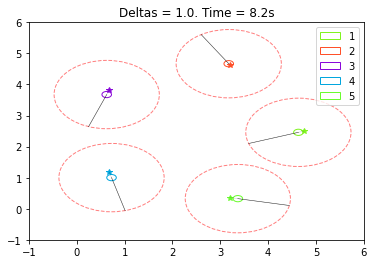

In [5]:
env.animate(trajectory, z_trajectory, deltas, format="mp4")